# 1. Perkenalan
      > Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan *objective* yang ingin dicapai.
   
   - Nama : Reyki Seprianza
   - Batch : FTDS 009

   
## Assignment Objectives

*Milestones 2* ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.


> Pada notebook ini saya akan melakukan deep learning dengan konsep **Computer Vision**
> - Dataset yang di gunakan adalah [Garbage Classification (12 classes)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification) 
> - Saya mempunyai tujuan untuk melatih model yang bisa memisahkan 12 kelas dari sampah yang di sediakan sesuai dengan dataset


   # 2. Import Libraries
      > *Cell* pertama pada *notebook* **harus berisi dan hanya berisi** semua *library* yang digunakan dalam *project*.

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

 
   # 3. Data Loading
      > Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [ ]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

cp: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘./kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q garbage-classification.zip -d images

replace images/garbage_classification/battery/battery1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls

garbage-classification.zip  images  kaggle  sample_data



  # 4. Exploratory Data Analysis (EDA)
      > Bagian ini berisi explorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, word cloud, dan lain sebagainya.

In [ ]:
os.listdir('/content/images/garbage_classification/')

['shoes',
 'clothes',
 'cardboard',
 'paper',
 'battery',
 'green-glass',
 'brown-glass',
 'trash',
 'metal',
 'white-glass',
 'biological',
 'plastic']

Data kita memiliki 12 kelas

In [ ]:
main_path= '/content/images/garbage_classification/'

In [ ]:
cats = ['shoes',
 'clothes',
 'cardboard',
 'paper',
 'battery',
 'green-glass',
 'brown-glass',
 'trash',
 'metal',
 'white-glass',
 'biological',
 'plastic']

kelas di masukan kedalam variabel `cats`

In [ ]:
for class_ in os.listdir(main_path):
    count_class = 0
    for photo in os.listdir(main_path + '/' + class_):
        count_class += 1
    print(str(class_) + " berisi " + str(count_class) + " photo")

shoes berisi 1977 photo
clothes berisi 5325 photo
cardboard berisi 891 photo
paper berisi 1050 photo
battery berisi 945 photo
green-glass berisi 629 photo
brown-glass berisi 607 photo
trash berisi 697 photo
metal berisi 769 photo
white-glass berisi 775 photo
biological berisi 985 photo
plastic berisi 865 photo


Bisa di lihat data kita berisi data yang cukup balance, hanya clothes yang datanya agak banyak dari yg lain

In [ ]:
%%time

data = pd.DataFrame()
for class_ in os.listdir(main_path):
    temp = pd.DataFrame()
    temp['images'] = np.nan
    temp['tipe'] = class_
    i = 0
    for photo in os.listdir(main_path + '/'+ class_):
        temp.loc[i, 'images'] = main_path  + class_ + "/" + photo
        temp.loc[i, 'tipe'] = class_
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp

CPU times: user 7.07 s, sys: 264 ms, total: 7.33 s
Wall time: 6.94 s


In [ ]:
data.shape

(15515, 2)

In [ ]:
data.duplicated().sum()

0

In [ ]:
data = data.sample(frac=1)
data.reset_index(drop=True, inplace=True)
data.head()

,images,tipe
0,/content/images/garbage_classification/clothes...,clothes
1,/content/images/garbage_classification/clothes...,clothes
2,/content/images/garbage_classification/biologi...,biological
3,/content/images/garbage_classification/trash/t...,trash
4,/content/images/garbage_classification/metal/m...,metal


Data pada direktori di rubah menjadi dataframe agar bisa di olah kedepannya

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

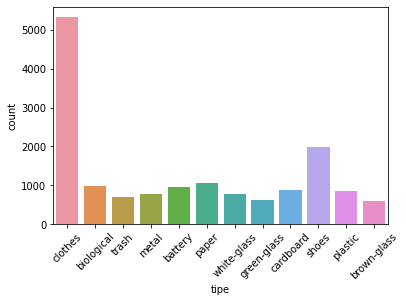

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data['tipe'])
plt.xticks(rotation="45")

Bisa di lihat pada grafik di atas untuk data yang kita miliki lumayan seimbang jumlahnya hanya pada bagian clothes yang berlebih namun asumsi saya hal ini tidak menjadi masalah dan data bisa di lanjutkan

In [ ]:
data['tipe'].value_counts()

clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: tipe, dtype: int64

In [ ]:
total_counts = 0

for class_ in os.listdir(main_path):
    count_class = 0
    for photo in os.listdir(main_path +'/' + class_):
        count_class += 1
        total_counts += 1
    print(str(class_) + " has " + str(count_class) + " photos")

shoes has 1977 photos
clothes has 5325 photos
cardboard has 891 photos
paper has 1050 photos
battery has 945 photos
green-glass has 629 photos
brown-glass has 607 photos
trash has 697 photos
metal has 769 photos
white-glass has 775 photos
biological has 985 photos
plastic has 865 photos


In [ ]:
total_counts

15515

Setelah data di jadikan bentuk dataframe kita melihat kembali isi data yang kita miliki tidak berubah dari data yg kita lihat sebelumnya, dan kita mempunyai 15515 photo yang tersedia 

In [ ]:
weights_ = dict()
for class_ in os.listdir(main_path):
    count_class = 0
    for photo in os.listdir(main_path + '/'  + class_):
        count_class += 1
    print(str(class_) + " has " + str((count_class/total_counts) * 100) + "% of photos")
    weights_[class_] = 1 - (count_class/total_counts)

shoes has 12.742507251047375% of photos
clothes has 34.32162423461166% of photos
cardboard has 5.74282951981953% of photos
paper has 6.767644215275539% of photos
battery has 6.090879793747986% of photos
green-glass has 4.054141153722204% of photos
brown-glass has 3.912342893973574% of photos
trash has 4.492426683854334% of photos
metal has 4.956493715758943% of photos
white-glass has 4.995165968417661% of photos
biological has 6.348694811472769% of photos
plastic has 5.575249758298421% of photos


In [ ]:
weights_

{'battery': 0.9390912020625202,
 'biological': 0.9365130518852723,
 'brown-glass': 0.9608765710602643,
 'cardboard': 0.9425717048018047,
 'clothes': 0.6567837576538833,
 'green-glass': 0.959458588462778,
 'metal': 0.9504350628424105,
 'paper': 0.9323235578472446,
 'plastic': 0.9442475024170158,
 'shoes': 0.8725749274895263,
 'trash': 0.9550757331614567,
 'white-glass': 0.9500483403158234}

weights pada masing-masing kelas berada di antara angka 7-9% , asumsi saya data ini masih bisa di lanjutkan

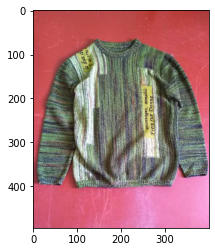

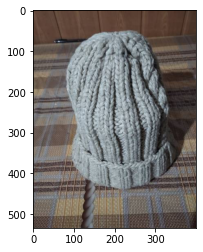

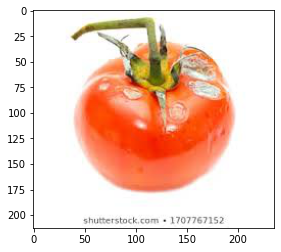

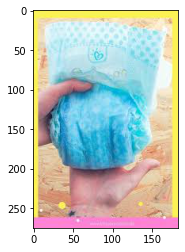

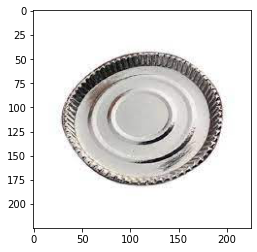

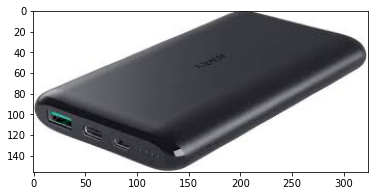

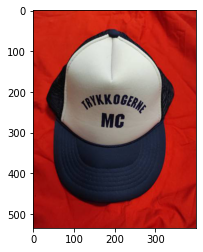

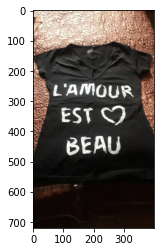

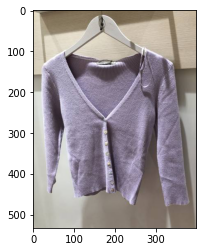

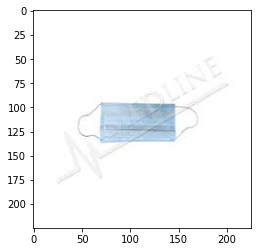

In [ ]:
import matplotlib.image as mpimg

for i in range(10):
    image = mpimg.imread(data.loc[i, 'images'])
    plt.imshow(image)
    plt.show()

## Resmue EDA

> - Data kita memiliki 12 kelas yaitu :
  ['shoes',
 'clothes',
 'cardboard',
 'paper',
 'battery',
 'green-glass',
 'brown-glass',
 'trash',
 'metal',
 'white-glass',
 'biological',
 'plastic']

> - Weight yang di miliki masing- masing kelas adalah :
 'shoes'= 0.87,
 'clothes'= 0.65,
 'cardboard'= 0.94,
 'paper'= 0.93,
 'battery'= 0.93,
 'green-glass'=0.95,
 'brown-glass'=0.96,
 'trash' = 0.95,
 'metal'= 0.95,
 'white-glass' 0.95,
 'biological'=0.93,
 'plastic'= 0.94


   # 5. Data Preprocessing
      > Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-val-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.   

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data, test_size=0.2, random_state=1, stratify = data['tipe'])
print(train_df.shape)
print(val_df.shape)

(12412, 2)
(3103, 2)


Memecah data menjadi train dan validation

In [ ]:
#menentukan ukuran shape dari gambar, seed dan batch untuk pemerosesan
img_height= 220
img_width= 220
SEED = 1
BATCH =128

In [ ]:
# create image generator

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='tipe',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='tipe',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=data,
    x_col='images',
    y_col='tipe',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    seed=SEED)

Found 12412 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 15515 validated image filenames belonging to 12 classes.


In [ ]:
ds_train.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

Pembagian kelas sudah di define disini sesuai dengan dataset kita yang memiliki 12 kelas


   # 6. Model Definition
      > Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model/arsitektur, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.


In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
    #ReduceLROnPlateau
]

Pada Callback saya memberikan modelcheckpoint agar bisa melakukan save pada model yang running pada colab

In [ ]:
inputs= [img_height,img_width,3]

my_model_1= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
my_model_1.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
my_model_1.add(MaxPooling2D(pool_size=2, strides=2))
# boleh coba dropout dll

#Conv 2
my_model_1.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
my_model_1.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
my_model_1.add(Conv2D(filters=16, kernel_size=3, activation= 'relu'))
my_model_1.add(MaxPooling2D(pool_size=2, strides=2))

my_model_1.add(Flatten())
my_model_1.add(Dense(units= 128, activation='relu'))
my_model_1.add(Dense(units=12, activation='softmax'))

Pada model ini saya menggunakan 3 filter yang masing- masing neuronnya adalah 64,32,16, setelah di lakukan flatten  data kita akan masuk ke hidden layer yang mempunyai 128 neuron dan mempunyai output sebanyak 12 dengan menggunakan aktivasi softmax

In [ ]:
my_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 218, 218, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 109, 109, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 107, 107, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 51, 51, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 16)      

Total parameter yang akan di lakukan kalkulasi pada model pertama kita adalah Total params: 1,306,556

In [ ]:
my_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

compailing model menggunakan optimizer `adam`


   # 7. Model Training
      > Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.
   

In [ ]:
history= my_model_1.fit(ds_train, batch_size= BATCH, 
                           epochs= 7, validation_data= ds_val,
                           callbacks= callbacks1) #bisa atur verbose

Epoch 1/7
97/97 [==============================] - 149s 2s/step - loss: 0.2345 - accuracy: 0.4165 - val_loss: 0.1824 - val_accuracy: 0.5243
Epoch 2/7
97/97 [==============================] - 148s 2s/step - loss: 0.1755 - accuracy: 0.5502 - val_loss: 0.1637 - val_accuracy: 0.5817
Epoch 3/7
97/97 [==============================] - 148s 2s/step - loss: 0.1620 - accuracy: 0.5848 - val_loss: 0.1555 - val_accuracy: 0.6097
Epoch 4/7
97/97 [==============================] - 148s 2s/step - loss: 0.1535 - accuracy: 0.6095 - val_loss: 0.1430 - val_accuracy: 0.6461
Epoch 5/7
97/97 [==============================] - 148s 2s/step - loss: 0.1496 - accuracy: 0.6264 - val_loss: 0.1386 - val_accuracy: 0.6613
Epoch 6/7
97/97 [==============================] - 148s 2s/step - loss: 0.1433 - accuracy: 0.6366 - val_loss: 0.1372 - val_accuracy: 0.6671
Epoch 7/7
97/97 [==============================] - 148s 2s/step - loss: 0.1391 - accuracy: 0.6509 - val_loss: 0.1303 - val_accuracy: 0.6813


waktu yang di butuhkan rata-rata epoch adalah 146 s atau 2,5 menit

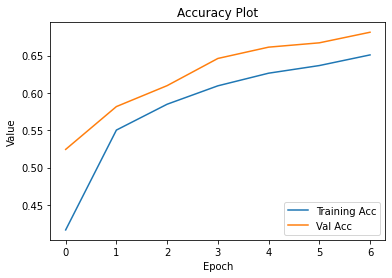

In [ ]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


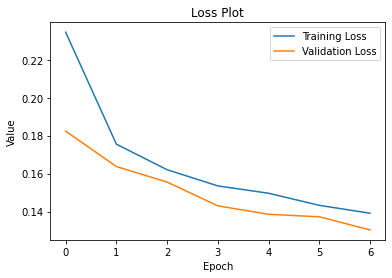

In [ ]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
val_results = my_model_1.evaluate(ds_val, verbose=0)
print(f'Validation Loss     : {val_results[0]:.4f}')
print(f'Validation Accuracy : {val_results[1]:.4f}')

Validation Loss     : 0.1303
Validation Accuracy : 0.6813


In [ ]:
y_true = ds_val.classes


In [ ]:
test_pred = my_model_1.predict(ds_val)

test_pred = np.argmax(test_pred, axis=1)

print(classification_report(ds_val.classes, test_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       189
           1       0.54      0.71      0.61       197
           2       0.79      0.65      0.71       121
           3       0.82      0.71      0.77       178
           4       0.84      0.91      0.87      1065
           5       0.83      0.79      0.81       126
           6       0.40      0.21      0.28       154
           7       0.61      0.71      0.66       210
           8       0.62      0.24      0.35       173
           9       0.49      0.61      0.54       395
          10       0.45      0.71      0.55       140
          11       0.50      0.06      0.11       155

    accuracy                           0.68      3103
   macro avg       0.63      0.58      0.58      3103
weighted avg       0.68      0.68      0.66      3103



Base modell kita masih membutuhkan improvement karena sangat tidak baik dalam memprediksi class


   # 8. Model Evaluation
      > Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. **Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya**.


In [ ]:
# transfer learning

# callback2
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 4), 
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
]

pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', \
                                                  input_shape=inputs, pooling='avg')
pretrained_model.trainable = False

Pada model improvment saya melakukan kembali model checkpoint dengan nama model_best2.hdf5 dan menambahkan pretrained model

In [ ]:
# Create the model


model_2 = Sequential()
model_2.add(pretrained_model)
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(12, activation='softmax'))

Arsitektur pada model kita saat ini kita menggunakan 2 hidden layer dengan menggunakan fully connected layer dan masing - masing neuron 128 dengan activation relu, dan output 12 class dengan activation softmax

In [ ]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 12)                1548      
                                                                 
Total params: 21,141,812
Trainable params: 280,332
Non-trainable params: 20,861,480
_________________________________________________________________


Model improvement kali ini mempunyai Total params: 21,141,812, seharusnya sudah bisa lebih baik lagi dalam melakukan prediksi

In [ ]:
model_2.compile(optimizer='adamax', loss='binary_crossentropy', metrics= ['accuracy'])

pada model ini compiler optimizer saya menggunakan `adamax`

In [ ]:
history2 = model_2.fit(ds_train, batch_size= BATCH, 
                           epochs= 9, validation_data= ds_val,
                           callbacks= callbacks2)

Epoch 1/9
97/97 [==============================] - 221s 2s/step - loss: 0.1620 - accuracy: 0.6714 - val_loss: 0.0790 - val_accuracy: 0.8666
Epoch 2/9
97/97 [==============================] - 167s 2s/step - loss: 0.0711 - accuracy: 0.8768 - val_loss: 0.0549 - val_accuracy: 0.9020
Epoch 3/9
97/97 [==============================] - 167s 2s/step - loss: 0.0550 - accuracy: 0.9059 - val_loss: 0.0468 - val_accuracy: 0.9127
Epoch 4/9
97/97 [==============================] - 167s 2s/step - loss: 0.0476 - accuracy: 0.9125 - val_loss: 0.0418 - val_accuracy: 0.9223
Epoch 5/9
97/97 [==============================] - 167s 2s/step - loss: 0.0430 - accuracy: 0.9201 - val_loss: 0.0383 - val_accuracy: 0.9291
Epoch 6/9
97/97 [==============================] - 167s 2s/step - loss: 0.0398 - accuracy: 0.9278 - val_loss: 0.0362 - val_accuracy: 0.9307
Epoch 7/9
97/97 [==============================] - 169s 2s/step - loss: 0.0367 - accuracy: 0.9318 - val_loss: 0.0346 - val_accuracy: 0.9314
Epoch 8/9
97/97 [===

Rata-rata waktu epoch yang di tempuh adalah 167s

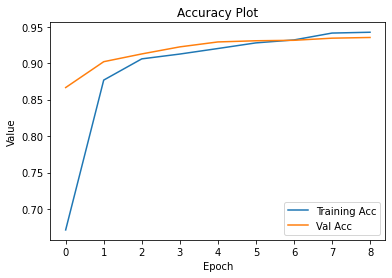

In [ ]:
plt.plot(history2.history['accuracy'], label='Training Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

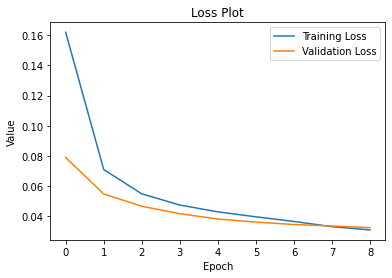

In [ ]:
#loss train & validation
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
test_pred = model_2.predict(ds_val)

test_pred = np.argmax(test_pred, axis=1)

print(classification_report(ds_val.classes, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       189
           1       0.97      0.98      0.97       197
           2       0.78      0.89      0.83       121
           3       0.96      0.91      0.93       178
           4       0.99      0.99      0.99      1065
           5       0.96      0.72      0.82       126
           6       0.87      0.82      0.85       154
           7       0.89      0.88      0.89       210
           8       0.86      0.79      0.82       173
           9       0.95      0.99      0.97       395
          10       0.96      0.96      0.96       140
          11       0.80      0.92      0.86       155

    accuracy                           0.94      3103
   macro avg       0.91      0.90      0.90      3103
weighted avg       0.94      0.94      0.93      3103



Model kita kali ini sudah sangat baik dalam memprediksi maka saya memutuskan menggunakan model ini untuk pengujian data inference dan deployment


   # 9. Model Saving
      > Dengan melihat hasil evaluasi model, pilihlah model terbaik untuk disimpan. Model terbaik ini akan digunakan kembali dalam melakukan deployment di Heroku.
   

Model yang kita gunakan adalah model_best2.hdf5 akan di ambil dari dari drive 


   # 10. Model Inference
       > Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.
   

In [ ]:
ds_val

In [ ]:
# Create labels
labels= {v:k for k,v in ds_val.class_indices.items()}


Menggenerate clas yang ada dan di simpan pada label

Saving tesmodel2.GIF to tesmodel2.GIF
Enter any category by index: 1
Invalid Value


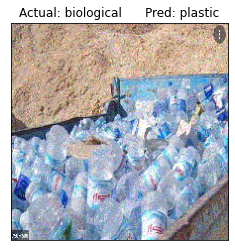

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
cat = int(input('Enter any category by index: '))

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(220,220))
  x = image.img_to_array(img)/255.
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_2.predict(images)
  pred = labels[np.argmax(classes)]
    
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.title('Actual: {}      Pred: {}'.format(labels[cat], pred))

  print('Invalid Value')


Gambar yang saya guunakan untup upload adalah gambar dari google yang secara random saya cari, pada case di atas, saya mengasumsikan data yang di upload adalah jenis sampah `biological` sedangkan model memprediksi gambar yang di upload adalah jenis sampah `plastic`, saya beranggapan model kita sudah sangat baik dalam menentukan perbedaan kelas

#   11. Pengambilan Kesimpulan
       > Pada bagian terakhir ini, **harus berisi** kesimpulan yang mencerminkan hasil yang didapat dengan *objective* yang sudah ditulis di bagian pengenalan.


- Dataset yang kita gunakan mempunyai 12 class dan model kita mengenali kelas tersebut dengan nomor seperti di bawah:
> 1.  'battery': 0,
> 2.  'biological': 1,
> 3.  'brown-glass': 2,
> 4.  'cardboard': 3,
> 5.  'clothes': 4,
> 6.  'green-glass': 5,
> 7.  'metal': 6,
> 8.  'paper': 7,
> 9.  'plastic': 8,
> 10.  'shoes': 9,
> 11.  'trash': 10,
> 12.  'white-glass': 11

- Dataset yang kita miliki memiliki distribusi data yang cukup bagus akan tetapi pada kategoti clothes memiliki jumlah data yang lebih banyak dari data lainnya `namun` model kita masih bisa menghandel data tersebut

- Model yang kita gunakan adalah model_best2.hdf5 akan di ambil dari dari drive dan akan di lakukan deployment pada heroku

- Data inference yang kita ambil dari google bisa di kenali deengan baik oleh model, biarpun saya menebak data inference itu adalah sampah `biological` namun model bisa menebak dengan benar bahwa sampah yang saya upload adalah sampah jenis `plastic`